In [1]:
import sys
sys.path.append('../../')
from src.load_data import *
from src.plot_functions import *
from src.hp_tuning_functions import *
import torch
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from pytorch_lightning.callbacks import RichProgressBar

In [2]:
from darts.models import TSMixerModel
from darts.models import TFTModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dwolffram (dwolffram-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


True

In [4]:
TEST_YEAR = 2019

In [5]:
NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

SHARED_ARGS = dict(
    output_chunk_length=HORIZON,
    likelihood=NegativeBinomialLikelihood(),
    # use_static_covariates=True,
    add_encoders=ENCODERS,
    pl_trainer_kwargs={
       "enable_progress_bar" : True,
       "enable_model_summary" : False,
       "accelerator" : "cpu",
       "callbacks" : [RichProgressBar(leave=True)]
    }
)

OPTIMIZER_DICT = {
    "Adam" : torch.optim.Adam,
    "AdamW" : torch.optim.AdamW,
    "SGD": torch.optim.SGD
}

# Load best parameters

In [6]:
params = get_best_parameters('tft', 2019)

WIS of best run: 305.44107378498546


In [7]:
params = get_best_parameters('hp-tuning', 'tsmixer', 2019)

WIS of best run: 292.50043813702626


In [8]:
name = params.pop('model')
test_year = params.pop('test_year')
optimizer = params.pop('optimizer')
use_covariates = params.pop('use_covariates')

In [9]:
params['optimizer_cls'] = OPTIMIZER_DICT[optimizer]

In [10]:
params

{'dropout': 0.3,
 'ff_size': 16,
 'n_epochs': 200,
 'norm_type': 'TimeBatchNorm2d',
 'activation': 'ReLU',
 'batch_size': 8,
 'num_blocks': 6,
 'hidden_size': 128,
 'normalize_before': False,
 'optimizer_kwargs': {'lr': 0.0005, 'weight_decay': 0.0001},
 'input_chunk_length': 8,
 'use_static_covariates': True,
 'optimizer_cls': torch.optim.adamw.AdamW}

In [11]:
model = TSMixerModel(
    **params,
    **SHARED_ARGS
)

In [10]:
model = TFTModel(
    **params,
    **SHARED_ARGS
)

# Load data

In [12]:
targets_train, targets_test, covariates = get_test_data(TEST_YEAR)

<Axes: xlabel='date'>

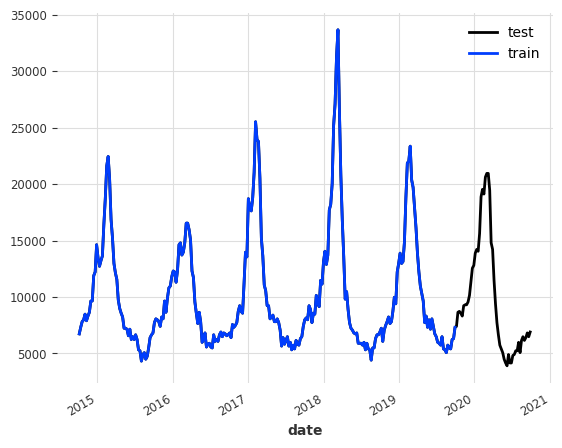

In [13]:
targets_test['icosari-sari-DE'].plot(label='test')
targets_train['icosari-sari-DE'].plot(label='train')

# Train model

In [14]:
HFC_PATH = f'../../data/pre-covid/cv-test-{name}-{test_year}.csv'
MODEL_PATH = f'../../models/pre-covid/cv-test-{name}-{test_year}.pt'

In [15]:
# model.reset_model()
model.fit(targets_train, past_covariates=covariates if use_covariates else None)

Epoch 199/199 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32/32 0:00:01 • 0:00:00 26.29it/s train_loss: 8.349

`Trainer.fit` stopped: `max_epochs=200` reached.


TSMixerModel(output_chunk_shift=0, hidden_size=128, ff_size=16, num_blocks=6, activation=ReLU, dropout=0.3, norm_type=TimeBatchNorm2d, normalize_before=False, use_static_covariates=True, n_epochs=200, batch_size=8, optimizer_kwargs={'lr': 0.0005, 'weight_decay': 0.0001}, input_chunk_length=8, optimizer_cls=<class 'torch.optim.adamw.AdamW'>, output_chunk_length=4, likelihood=NegativeBinomialLikelihood(), add_encoders={'datetime_attribute': {'future': ['month', 'weekofyear']}}, pl_trainer_kwargs={'enable_progress_bar': True, 'enable_model_summary': False, 'accelerator': 'cpu', 'callbacks': [<pytorch_lightning.callbacks.progress.rich_progress.RichProgressBar object at 0x7fc6c0758700>]})

In [18]:
model.save(MODEL_PATH)

In [14]:
model = TSMixerModel.load(MODEL_PATH)

In [14]:
model = TFTModel.load(MODEL_PATH)

In [16]:
test_start = targets_train.end_time() + targets_train.freq

In [17]:
hfc = model.historical_forecasts(
    series=targets_test,
    past_covariates=covariates if use_covariates else None,
    start=test_start,
    forecast_horizon=HORIZON,
    stride=1,
    last_points_only=False,
    retrain=False,
    verbose=False,
    num_samples=NUM_SAMPLES,
    enable_optimization=False
)

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

In [18]:
df = reshape_hfc(hfc)

In [41]:
df.to_csv(HFC_PATH, index=False)
print(HFC_PATH)

../../data/pre-covid/cv-test-tsmixer-2019.csv


In [42]:
# df = pd.read_csv(HFC_PATH)
# print(HFC_PATH)

In [19]:
model.supports_optimized_historical_forecasts

True

In [19]:
df_plot = prepare_plot_data(df, targets_test[test_start : ])

In [17]:
compute_validation_score(model, targets_train, targets_test, covariates if use_covariates else None, 
                                         HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS)

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 0:00:30 • 0:00:00 0.24it/s

260.3102981049563

In [18]:
validation_start = targets_train.end_time() + targets_train.freq

In [25]:
scores = model.backtest(
    series=targets_test,
    past_covariates=covariates if use_covariates else None,
    historical_forecasts=hfc,
    start=validation_start,
    forecast_horizon=HORIZON,
    stride=1,
    last_points_only=False,
    retrain=False,
    verbose=False,
    num_samples=NUM_SAMPLES,
    metric=METRIC, 
    metric_kwargs=METRIC_KWARGS
)

score = np.mean(scores)

In [26]:
score

294.6743303571429

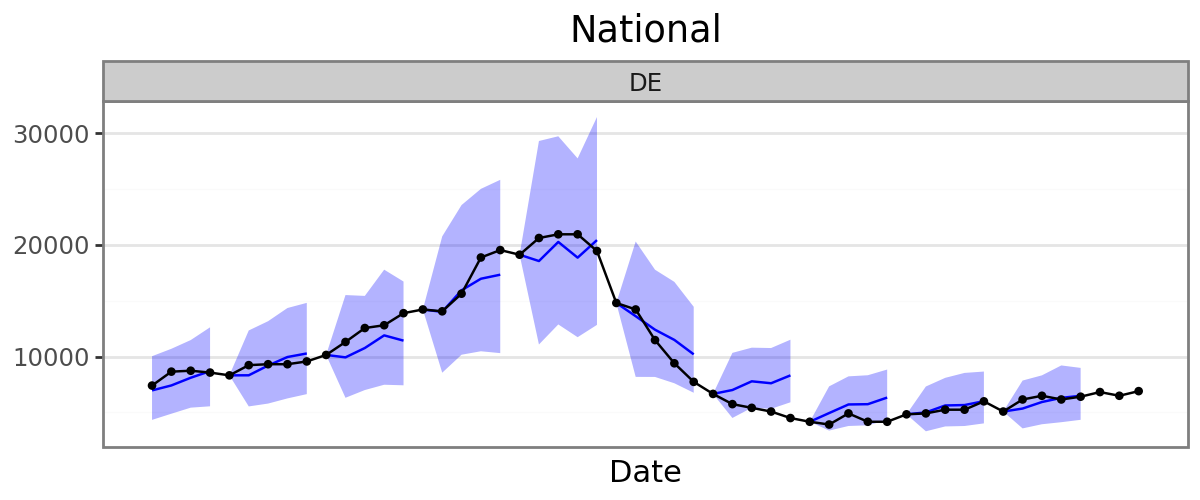

In [20]:
plot_forecasts(df_plot, 'national')

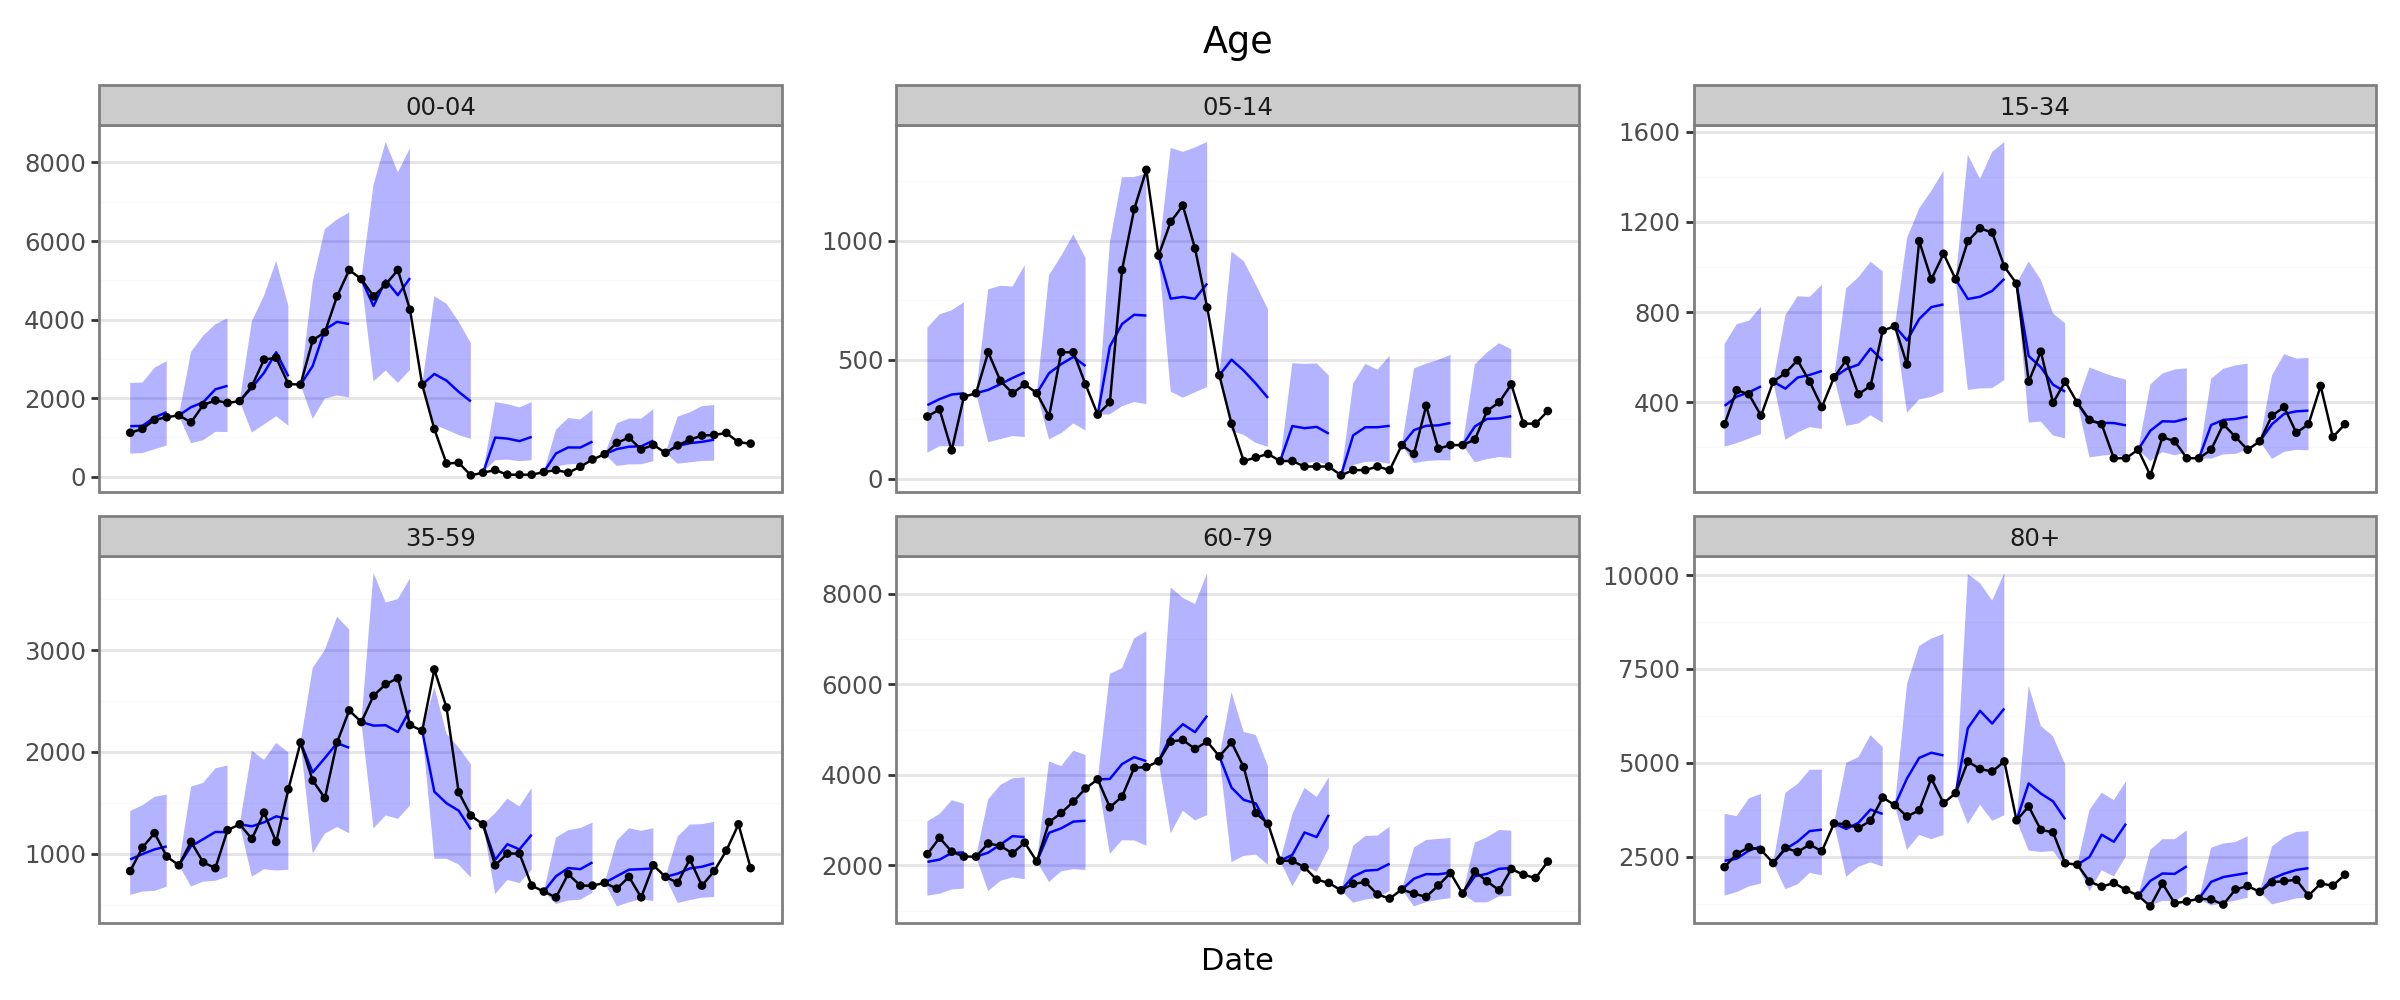

In [21]:
plot_forecasts(df_plot, 'age')

# TSMixer

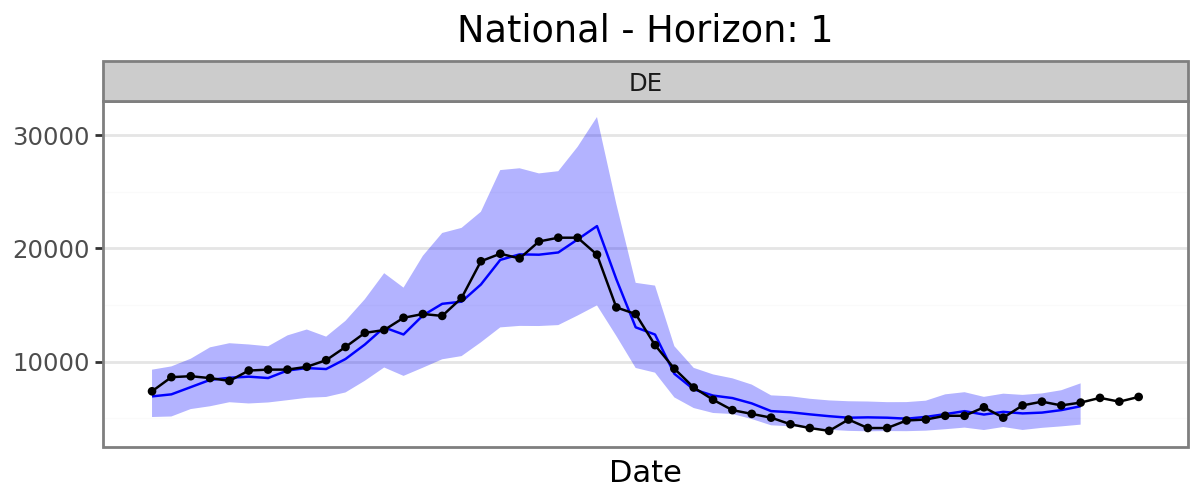

In [46]:
plot_forecasts(df_plot, 'national', horizon=1)

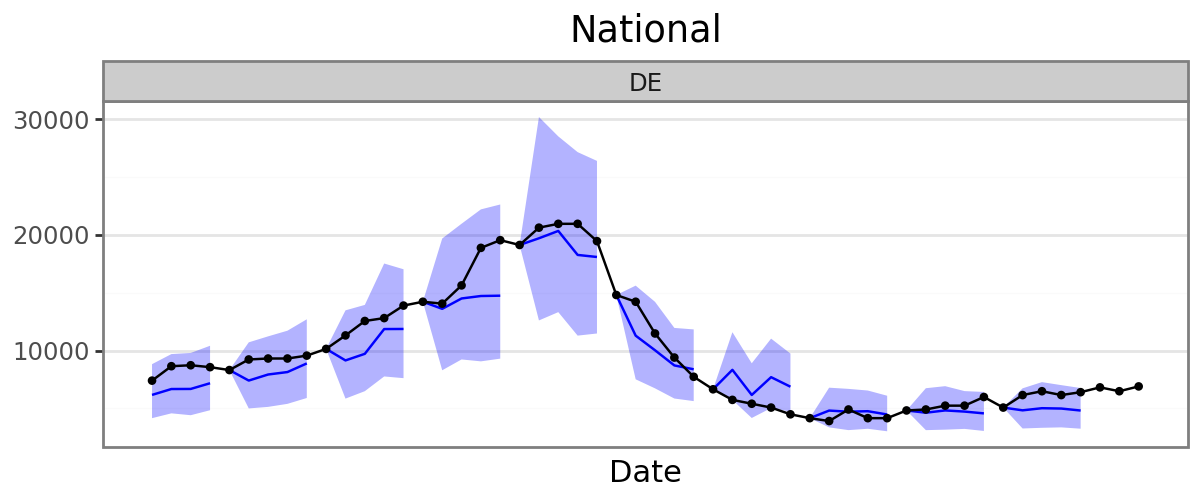

In [ ]:
plot_forecasts(df_plot, 'national')

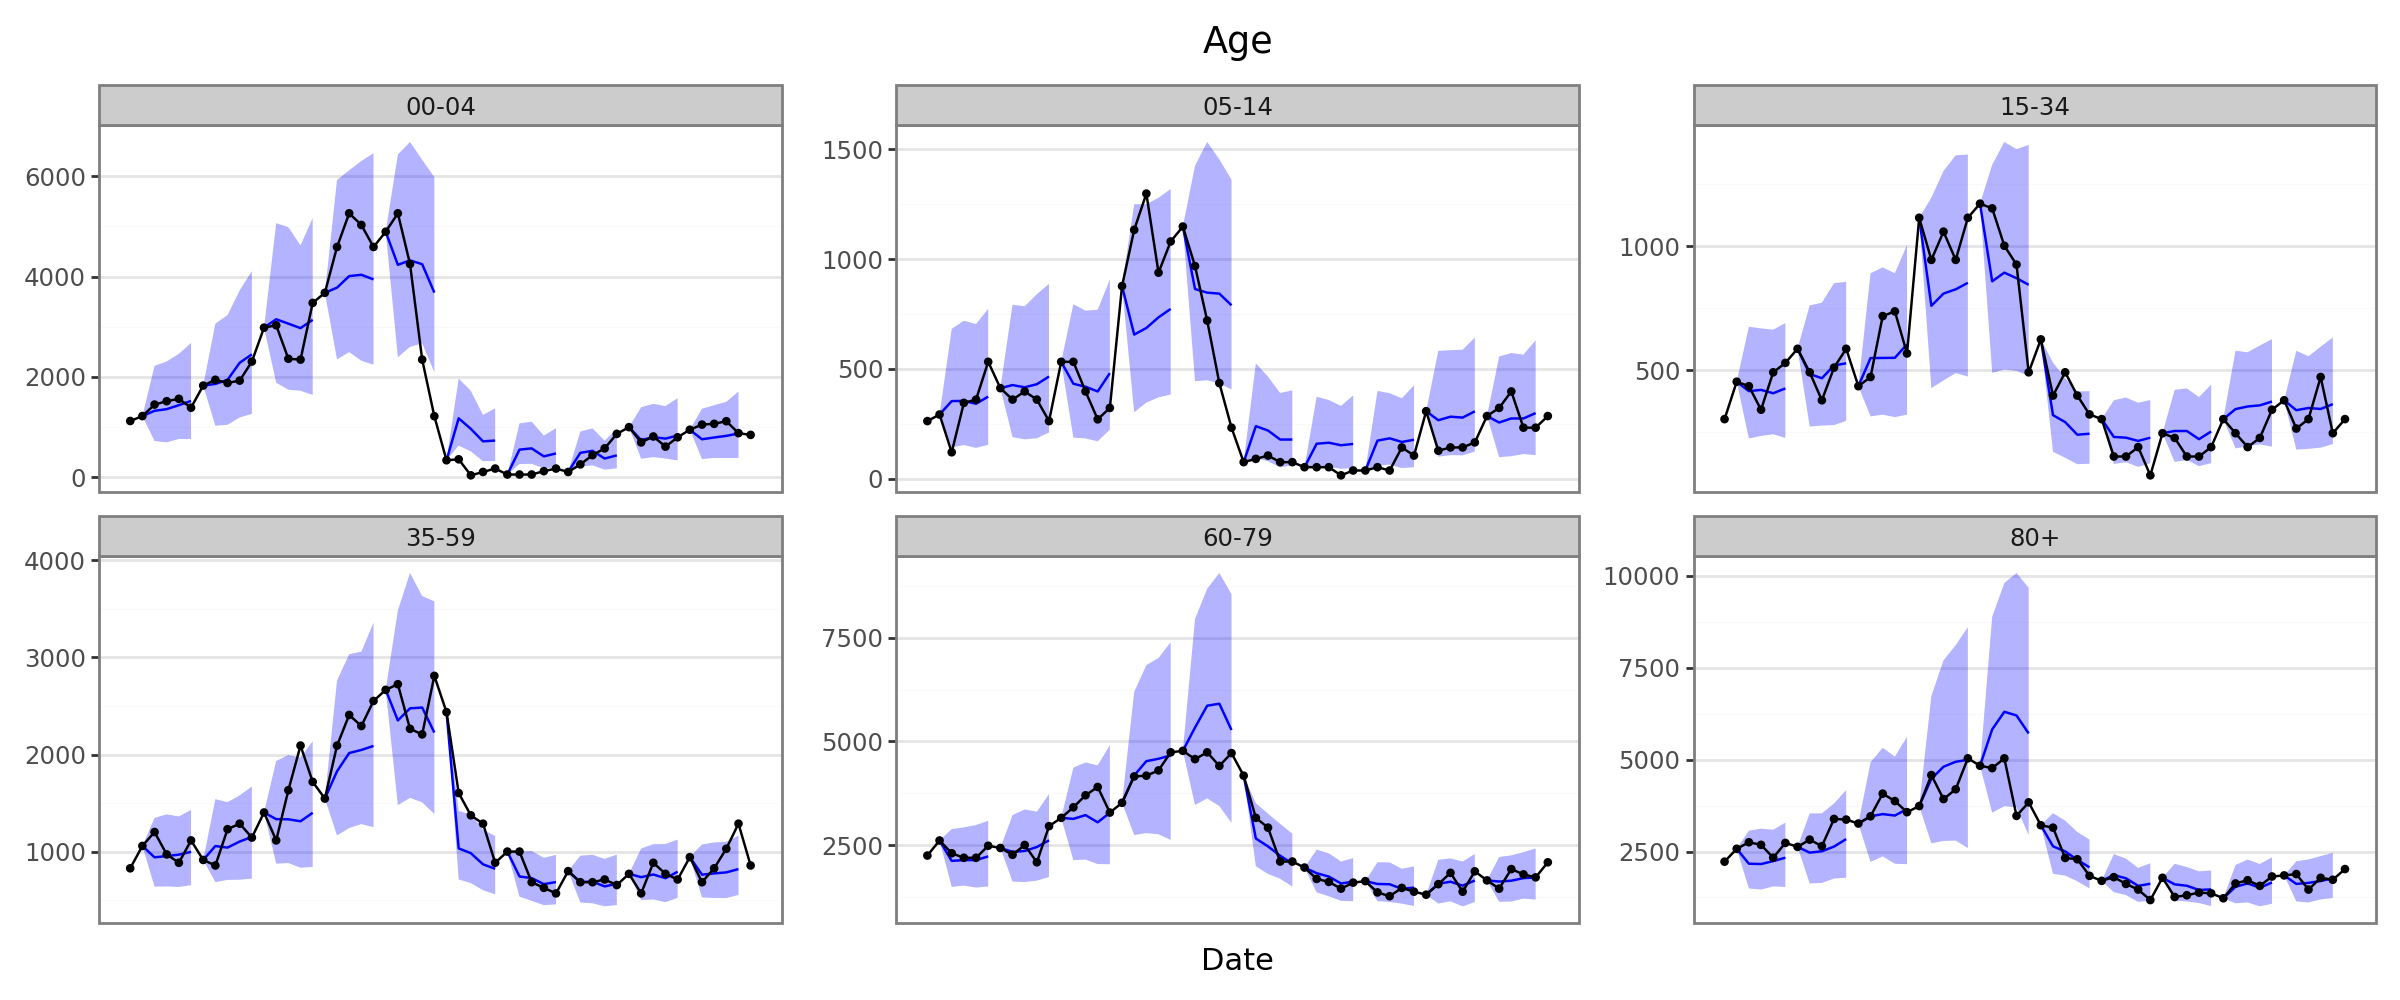

In [53]:
plot_forecasts(df_plot, 'age', 2)

In [17]:
# TFT

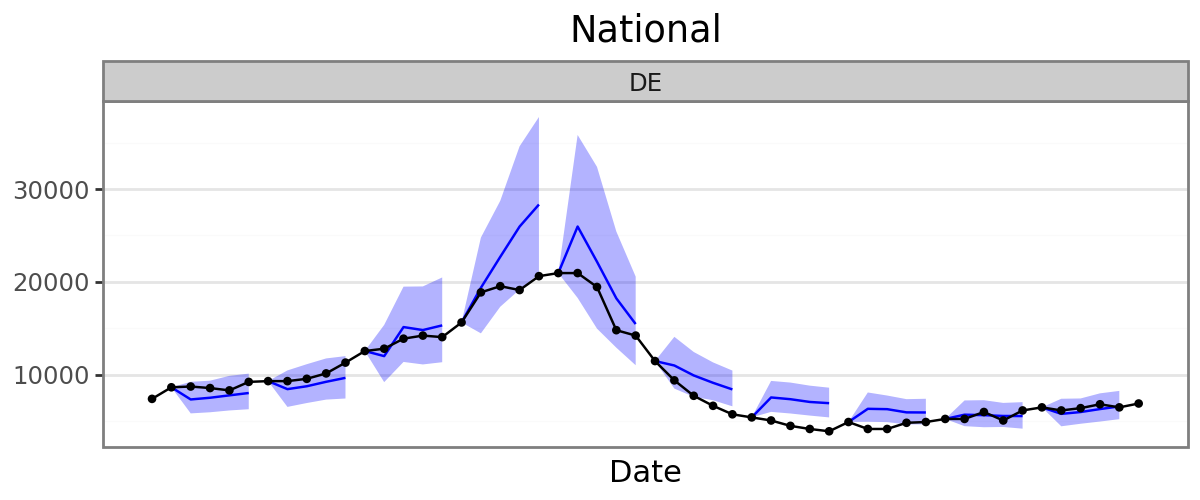

In [23]:
plot_forecasts(df_plot, 'national', 2)

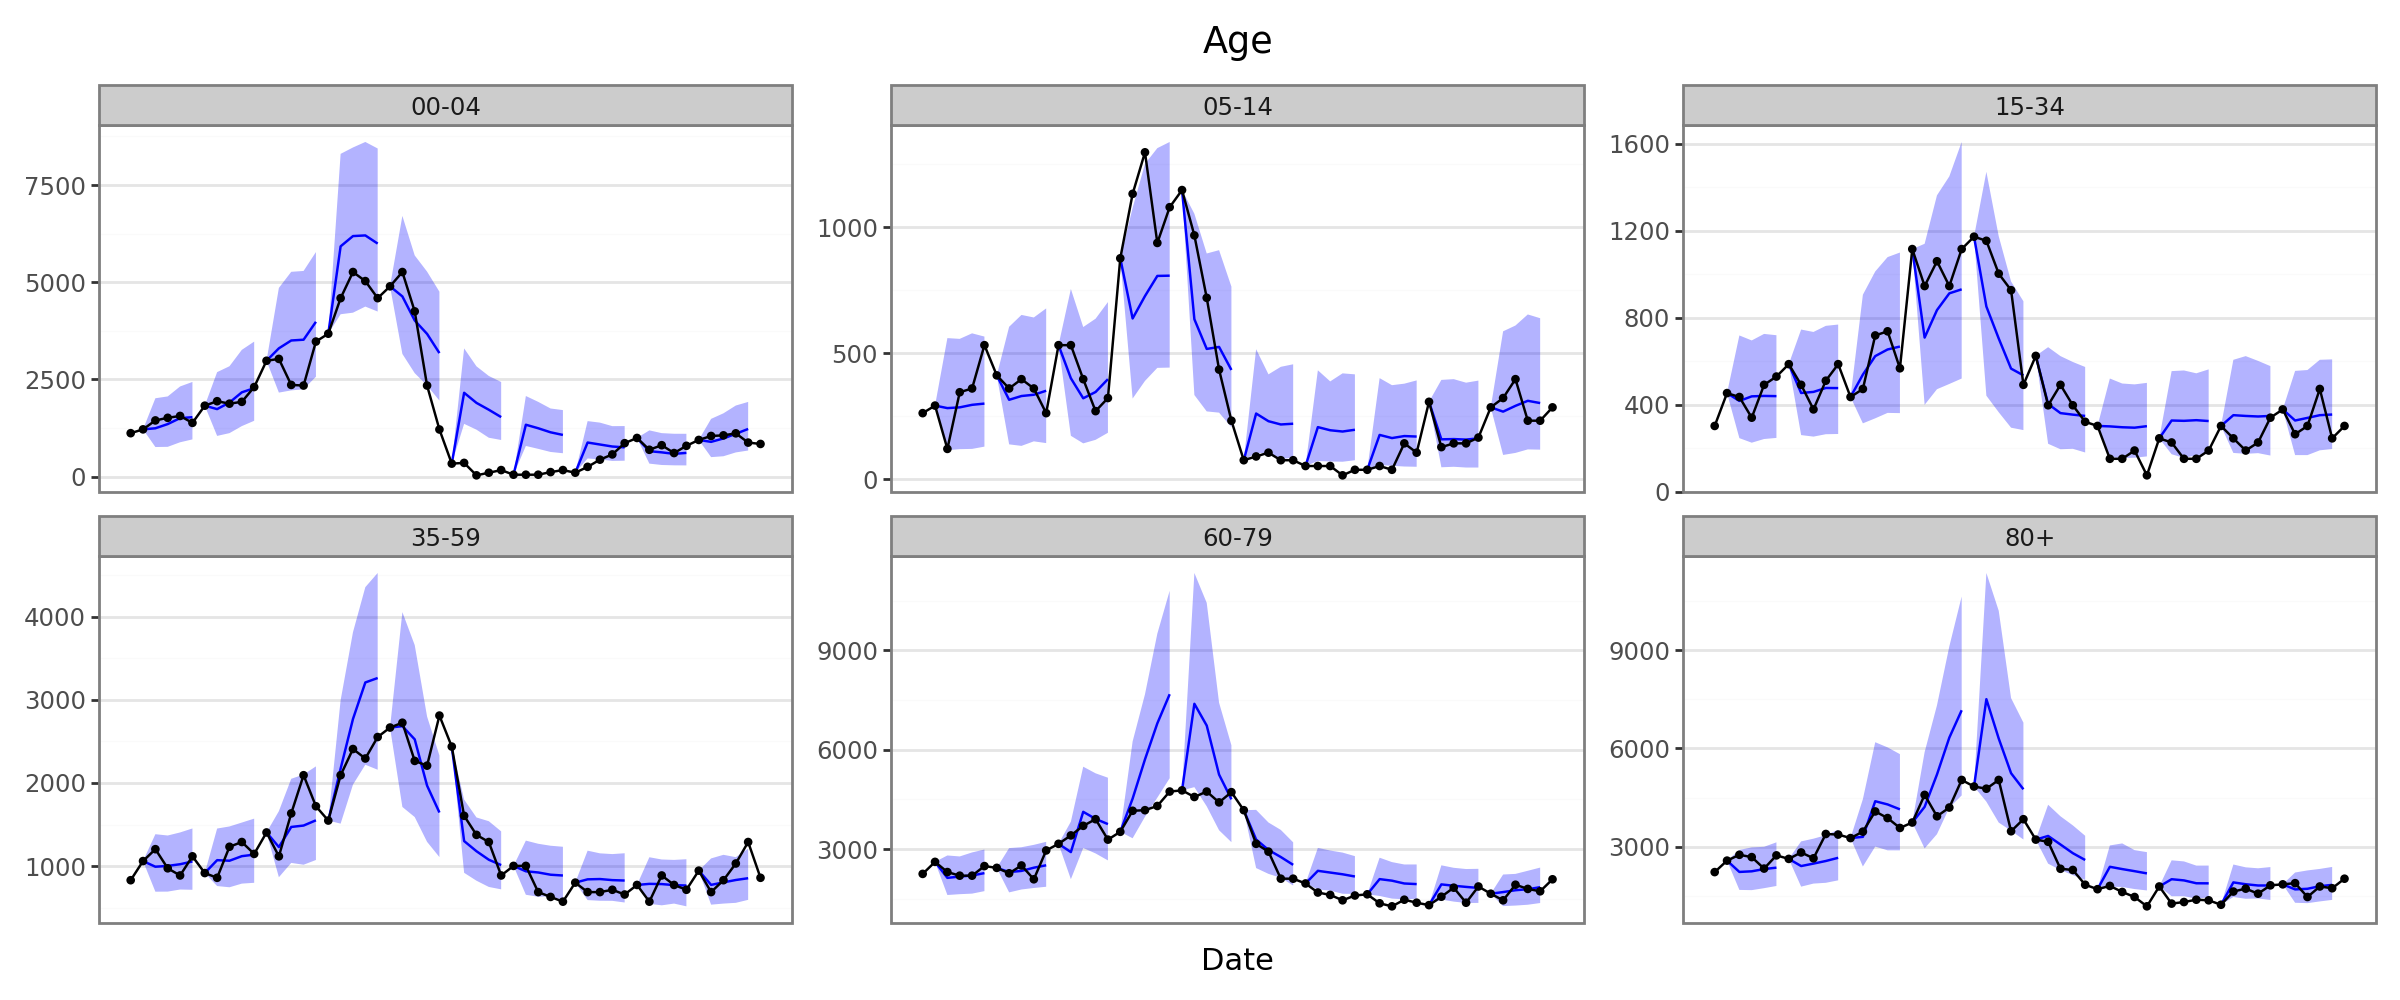

In [24]:
plot_forecasts(df_plot, 'age', 2)